# Question 1: GPT-2 style autoregressive language model

In [1]:
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as data
from models.attention import MultiHeadAttention
from models.embedder import Embedder, FeedForward, Norm, PositionalEncoder, get_clones
from transformers import GPT2Tokenizer

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Decoder

* the first attention mechanism in each decoder layer is self-attention
    * operates solely within the decoder
    * focuses on the target sequence
    * we're going to keep this
* the second attention mechanism is the encoder-decoder attention
    * this is "cross-attention"
    * One of the sequences serves as a query input, while the other as a key and value inputs
* in a GPT-2-style autoregressive model
    * the encoder-decoder attention is not used because there is no distinct encoder phase
    * the model is solely based on a stacked decoder-like architecture with self-attention layers
    * this only attends to previous positions in the input sequence (using a no-peak mask)

In [3]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.norm_2 = Norm(d_model)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

Since there's no longer an encoder output (`e_outputs`), we can remove it.

In [4]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, trg_mask)
        return self.norm(x)

## Transformer

* the Transformer below essentially functions like an autoregressive language model, similar to GPT-2.
* This model doesn't have an encoder and uses only a decoder.
* we're now using a single vocab size since we don't have a source and target vocab.

```python
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout) # remove this
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        # self.out = nn.Linear(d_model, trg_vocab)

    def forward(self, src, trg, src_mask, trg_mask): # now only target vocab
        e_outputs = self.encoder(src, src_mask)
        # print("DECODER")
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        # output = self.out(d_output) # replacing this with tied vocabulary
        output = torch.matmul(d_output, self.decoder.embed.embed.weight.t())
        return output
```

In [5]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, device):
        super().__init__()
        self.device = device
        self.vocab_size = vocab_size
        self.decoder = Decoder(vocab_size, d_model, N, heads, dropout)

    def forward(self, trg, trg_mask):
        d_output = self.decoder(trg, trg_mask)
        output = torch.matmul(d_output, self.decoder.embed.embed.weight.t())
        return output

## No-Peak Mask

`nopeak_mask`: create an upper triangular matrix using `torch.triu()`

In [6]:
def nopeak_mask(size, device):
    """
    Create a no-peak (or future token) mask for a given size.

    Parameters:
        size (int): The size of the sequence.
        device (torch.device): The device to create the mask on.

    Returns:
        torch.Tensor: A boolean mask tensor
    """
    np_mask = ~torch.triu(torch.ones((1, size, size), device=device), diagonal=1).bool()
    return np_mask

## Data Feeder

* preparing a dataset and an iterator for training using torchtext
* Source: https://gmihaila.github.io/ml_things/tutorial_notebooks/pytorchtext_bucketiterator/

### Tokenizer

* We're going to use the GPT2 tokenizer.
* We're going to tokenize each line and then include EOS at the end.
* Furthermore, our results with the GPT2 tokenizer were the best with our previous assignment.

In [7]:
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2")

In [8]:
TOKENIZER.add_special_tokens(
    {"pad_token": "[PAD]", "bos_token": "<sos>", "eos_token": "<eos>"}
)
TOKENIZER.pad_token_id, TOKENIZER.bos_token_id, TOKENIZER.eos_token_id

(50257, 50258, 50259)

### Tokenization

In [9]:
def load_and_tokenize_file(file_path, tokenizer):
    """
    Reads a text file and tokenizes it into words, prepending and appending
    special tokens to each line.

    Parameters:
        file_path (str): The path to the text file.

    Returns:
        list of list of str: A list where each element is a
        list of tokens from each line of the file, including special tokens.
    """
    with open(file_path, "r", encoding="utf-8") as file:
        lines = [line.strip() for line in file if line.strip()]

    # Tokenize each line with special tokens and store tokens
    all_token_ids = []
    for line in lines:
        modified_line = f"<sos> {line} <eos>"  # Add special tokens
        tokens = tokenizer.tokenize(modified_line)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        all_token_ids.extend(token_ids)

    return all_token_ids

In [10]:
train_tokens = load_and_tokenize_file("data/wiki2.train.txt", TOKENIZER)

```txt
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 ...
```

In [11]:
train_tokens[0:25]

[50258,
 796,
 569,
 18354,
 7496,
 17740,
 6711,
 796,
 220,
 50259,
 50258,
 2311,
 73,
 13090,
 645,
 569,
 18354,
 7496,
 513,
 1058,
 1279,
 2954,
 29,
 17740,
 357]

In [12]:
len(train_tokens)

2446247

### Batching and Creating Sequences

In [13]:
class BatchGenerator:
    def __init__(self, data, seq_len=512, batch_size=32, pad_token_id=0):
        """
        Initializes the batch generator.

        Parameters:
            data (list of int): The flat list of all token IDs.
            seq_len (int): The number of tokens in each sequence.
            batch_size (int): The number of sequences in each batch.
            pad_token_id (int): Token ID used for padding.
        """
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.pad_token_id = pad_token_id
        self.total_data_len = len(data)
        self.steps_per_epoch = (
            self.total_data_len + self.batch_size * self.seq_len - 1
        ) // (self.seq_len * self.batch_size)

    def generate(self):
        """
        A generator that yields batches of data.

        Yields:
            np.array: A batch of data with shape (batch_size, seq_len).
        """
        start_index = 0
        while True:
            # Calculate the end index of the batch
            end_index = start_index + self.batch_size * self.seq_len
            if end_index > self.total_data_len:
                # Handle end of array with padding if not enough data to complete the batch
                residual_data = self.data[start_index : self.total_data_len]
                padding_needed = end_index - self.total_data_len
                padded_data = np.full(padding_needed, self.pad_token_id, dtype=int)
                batch_data = np.concatenate((residual_data, padded_data))
                start_index = (
                    self.total_data_len
                )  # Set start_index to total_data_len to end generation
            else:
                batch_data = self.data[start_index:end_index]
                start_index += self.batch_size * self.seq_len

            # Reshape batch data to the required dimensions
            batch_data = np.array(batch_data).reshape(self.batch_size, self.seq_len)
            yield batch_data

            if start_index >= self.total_data_len:
                break

### Sample Batch

Note that our sequence length is 512 and batch size is 32.

In [14]:
train_batch_generator = BatchGenerator(
    train_tokens, seq_len=512, batch_size=32, pad_token_id=TOKENIZER.pad_token_id
)

for batch in train_batch_generator.generate():
    print(batch.shape)
    for token_ids in batch:
        print(token_ids)
        text = TOKENIZER.decode(token_ids, skip_special_tokens=True)
        print(text)
        break
    break

(32, 512)
[50258   796   569 18354  7496 17740  6711   796   220 50259 50258  2311
    73 13090   645   569 18354  7496   513  1058  1279  2954    29 17740
   357  4960  1058 10545   230    99   161   254   112  5641 44444  9202
 25084 24440 12675 11839    18   837  6578   764   569 18354  7496   286
   262 30193   513  1267   837  8811  6412   284   355   569 18354  7496
 17740  6711  2354  2869   837   318   257 16106  2597  2488    12    31
  2712  2008   983  4166   416 29490   290  6343    13 44206   329   262
 14047 44685   764 28728   287  3269  2813   287  2869   837   340   318
   262  2368   983   287   262   569 18354  7496  2168   764  1279  2954
    29   262   976 21748   286 16106   290  1103  2488    12    31   640
 11327   355   663 27677   837   262  1621  4539 10730   284   262   717
   983   290  5679   262   366 17871  5321   366   837   257 23634  2422
  4326  7351   262  3277   286  7096   544  1141   262  5498  1898  6839
  1810   508  1620  3200  2042  4560   29

the decoded version of the same text is available with its tokenized tensor representation.

In [15]:
mask = nopeak_mask(size=512, device=DEVICE)

In [16]:
mask

tensor([[[ True, False, False,  ..., False, False, False],
         [ True,  True, False,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ...,  True, False, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True,  True]]], device='cuda:0')

In [17]:
mask.shape

torch.Size([1, 512, 512])

## Training

In [18]:
def get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device="cpu"):
    """Initialize and return the Transformer model

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the model.
        N (int): The number of decoder layers.
        heads (int): The number of attention heads.
        dropout (float): The dropout rate.

    Returns:
        Transformer: The initialized Transformer model.
    """
    model = Transformer(vocab_size, d_model, N, heads, dropout, device)
    model.to(device)
    return model

In [19]:
def train_model(
    model, train_generator, valid_generator, optimizer, device, epochs, print_every=50
):
    train_losses = []
    train_perplexities = []
    valid_losses = []
    valid_perplexities = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        intermediate_train_loss = 0
        start = time.time()

        # Adjust to use the generator
        for i, batch in enumerate(train_generator.generate()):
            batch_tensor = torch.tensor(batch).to(device)
            no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

            # https://github.com/SamLynnEvans/Transformer/blob/master/Batch.py#L20
            preds = model(batch_tensor, no_peak_mask)
            preds = preds[:, :-1, :]  # Exclude the last time step predictions
            ys = (
                batch_tensor[:, 1:].contiguous().view(-1)
            )  # Targets shifted by one position

            optimizer.zero_grad()
            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            intermediate_train_loss += loss.item()

            if (i + 1) % print_every == 0:
                p = int(100 * (i + 1) / train_generator.steps_per_epoch)
                avg_loss = intermediate_train_loss / print_every
                print(
                    f"{int((time.time() - start) // 60)}m: epoch {epoch + 1} [{p}%] Train loss = {avg_loss:.3f}",
                    end="\r",
                )
                intermediate_train_loss = 0

            if (i + 1) == train_generator.steps_per_epoch:
                break  # Stop after processing all steps per epoch

        avg_train_loss = total_train_loss / train_generator.steps_per_epoch
        train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
        train_losses.append(avg_train_loss)
        train_perplexities.append(train_perplexity)

        # Validation Phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valid_generator.generate()):
                batch_tensor = torch.tensor(batch).to(device)
                no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

                preds = model(batch_tensor, no_peak_mask)
                preds = preds[:, :-1, :]
                ys = batch_tensor[:, 1:].contiguous().view(-1)

                loss = F.cross_entropy(
                    preds.reshape(-1, preds.size(-1)),
                    ys,
                    ignore_index=TOKENIZER.pad_token_id,
                )
                total_valid_loss += loss.item()

                if (i + 1) == valid_generator.steps_per_epoch:
                    break  # Stop after processing all steps per epoch

        avg_valid_loss = total_valid_loss / valid_generator.steps_per_epoch
        valid_perplexity = torch.exp(torch.tensor(avg_valid_loss)).item()
        valid_losses.append(avg_valid_loss)
        valid_perplexities.append(valid_perplexity)

        print(
            f"Epoch {epoch + 1}: Train loss = {avg_train_loss:.3f}, Train Perplexity = {train_perplexity:.3f}"
        )
        print(
            f"Epoch {epoch + 1}: Validation loss = {avg_valid_loss:.3f}, Validation Perplexity = {valid_perplexity:.3f}"
        )

    return train_losses, train_perplexities, valid_losses, valid_perplexities

In [20]:
train_tokens = load_and_tokenize_file("data/wiki2.train.txt", TOKENIZER)
train_batch_generator = BatchGenerator(
    train_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

valid_tokens = load_and_tokenize_file("data/wiki2.valid.txt", TOKENIZER)
valid_batch_generator = BatchGenerator(
    valid_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

In [21]:
vocab_size = len(TOKENIZER)
model = get_model(vocab_size, d_model=512, N=7, heads=8, dropout=0.05, device=DEVICE)
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.001,
)

In [22]:
results = train_model(
    model,
    train_batch_generator,
    valid_batch_generator,
    optimizer,
    DEVICE,
    epochs=2,
    print_every=5,
)

Epoch 1: Train loss = 38.596, Train Perplexity = 57839203588767744.000
Epoch 1: Validation loss = 8.720, Validation Perplexity = 6122.242
Epoch 2: Train loss = 9.373, Train Perplexity = 11771.975
Epoch 2: Validation loss = 6.582, Validation Perplexity = 721.709


```python
Epoch 1: Train loss = 38.596, Train Perplexity = 57839203588767744.000
Epoch 1: Validation loss = 8.720, Validation Perplexity = 6122.242
Epoch 2: Train loss = 9.373, Train Perplexity = 11771.975
Epoch 2: Validation loss = 6.582, Validation Perplexity = 721.709
```

Note that our losses and perplexities are very low.

In [23]:
torch.cuda.get_device_name(0)

'NVIDIA A10G'

In [24]:
train_losses, train_perplexities, valid_losses, valid_perplexities = results

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [26]:
epochs = list(range(1, len(train_losses) + 1))
train_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Train Perplexity": train_perplexities,
    }
)

valid_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Validation Loss": valid_losses,
        "Validation Perplexity": valid_perplexities,
    }
)

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


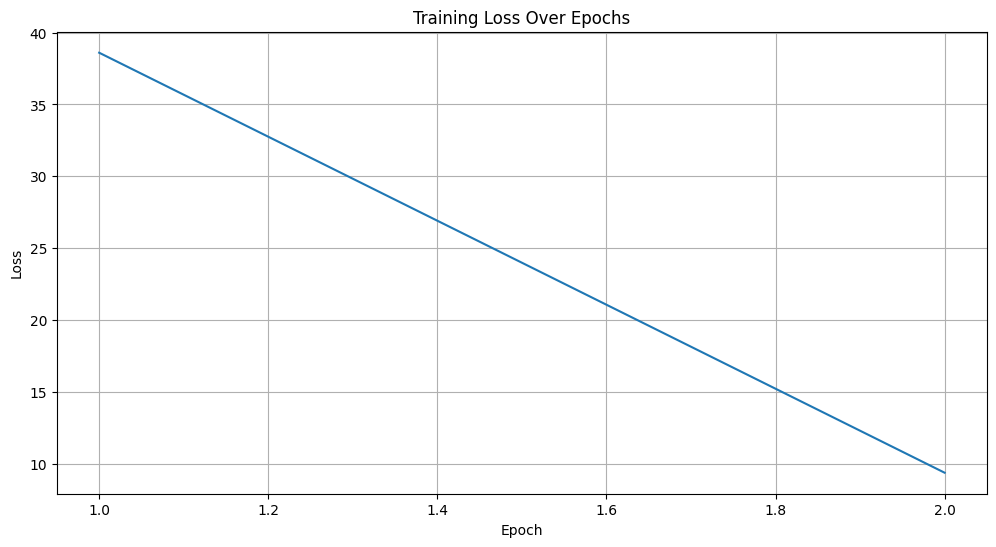

In [27]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


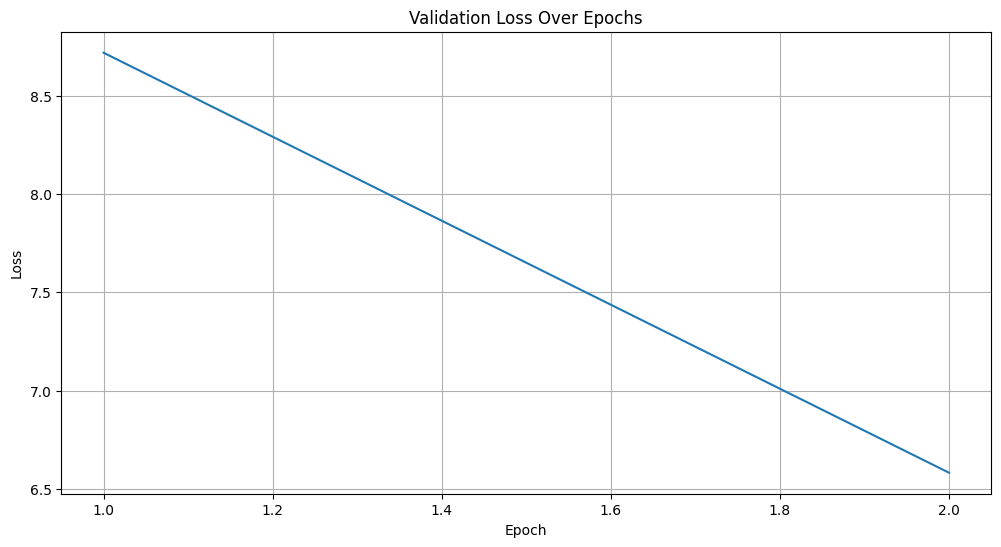

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


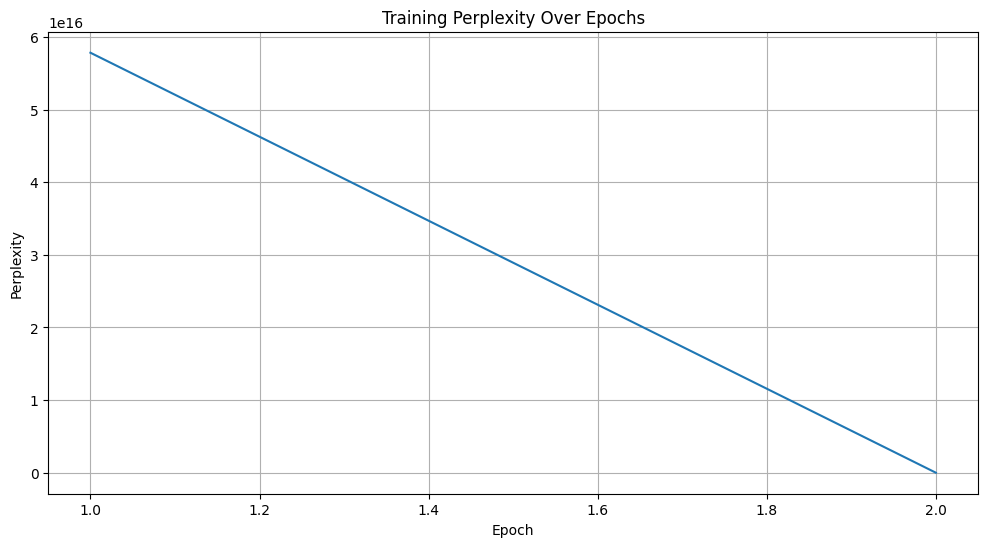

In [29]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Perplexity")
plt.title("Training Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


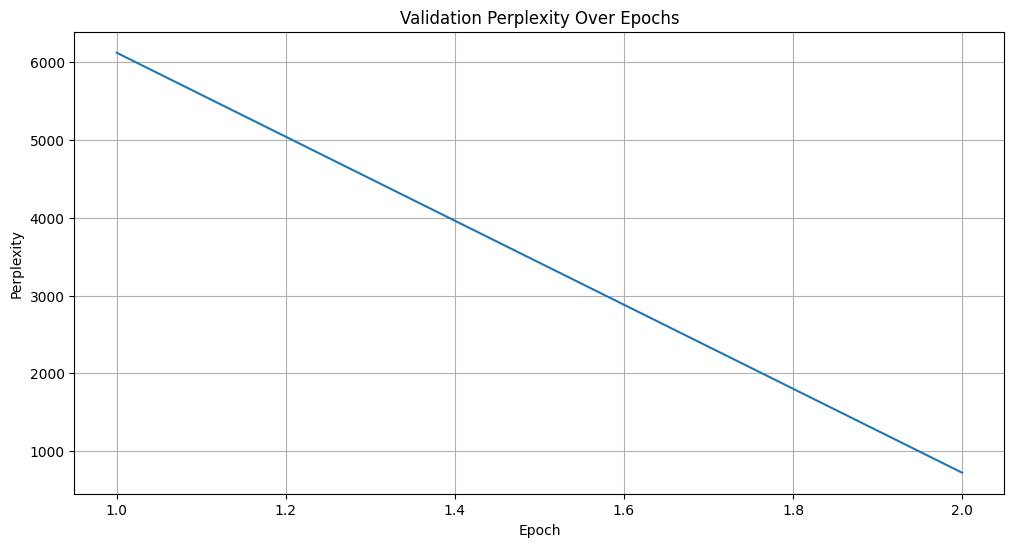

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Perplexity")
plt.title("Validation Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()